# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install requirements

In [1]:
%pip install --upgrade torch
%pip install --upgrade torchtext
#%pip install --upgrade torchvision
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu113/torch_nightly.html -U
%pip install pytorch-lightning
%pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0.dev20220622+cu113
    Uninstalling torch-1.13.0.dev20220622+cu113:
      Successfully uninstalled torch-1.13.0.dev20220622+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.0.dev20220622+cu113 requires torch==1.13.0.dev20220622+cu113, but you have torch 1.11.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/nightly/cu113/torch_nightly.html
     |██████████████▌                 | 834.1 MB 1.0 

# Import relevant libraries

In [2]:
import sys
import os
module_path = os.path.join(os.path.abspath(''), "drive/MyDrive/Master_Thesis_Profactor/zdmp/")
if module_path not in sys.path:
  sys.path.append(module_path)

import zdmp
from zdmp_utils.lightning_classifier import Classifier

import timm
import torch
import torchvision
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import numpy as np
import warnings
import datetime

from zdmp_utils.external_utils.vision_transformer import VitGenerator
from zdmp_utils.external_utils.swin_transformer import SwinGenerator

In [3]:
def save_model(model, name):
    date = datetime.date.today()
    path = os.path.join(
        "/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models",
        f"{name}_{date.year}_{date.month}_{date.day}.pth"
    )
    torch.save(model, path)

In [ ]:
def save_jit(mode, name):
    path = os.path.join(
        "/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/jit",
        f"jit_{name}.pth"
    )
    script = torch.jit.script(model.state_dict())
    script.save(path)

# Available models

* 0 - LuNA
* 1 - AlexNet
* 2 - ResNet
* 3 - EfficientNetV2
* 4 - ConvNext
* 5 - ViT (Vision Transformer)
* 6 - Swin (Shifted Window
* 7 - DINO

In [4]:
model_names = ["luna", "alexnet", "resnet", "efficientnetv2", "convnext", "vit", "swin_t", "dino"]
model_name = model_names[6]

## Prepare the Dataset and Dataloader

In [5]:
# Make the results reproducible
pl.seed_everything(42)

# Prepare dataset
ds_train, ds_vali = zdmp.get_train_data(vit=(model_names.index(model_name)>=5))
ds_test = zdmp.get_test_data(vit=(model_names.index(model_name)>=5))

# Prepare Dataloaders
dl_train = DataLoader(ds_train, batch_size=16, num_workers=2, shuffle=True)
dl_vali = DataLoader(ds_vali, batch_size=16, num_workers=2)
dl_test = DataLoader(ds_test, batch_size=16, num_workers=2)

Global seed set to 42


zdmp - ViT size - True
get_data - ViT size - True
transform - ViT size - True


## Prepare the selected model

In [ ]:
class DiNo(torch.nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        self.backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
        self.head = torch.nn.Linear(384, num_classes) 

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [ ]:
# Prepare model
if model_name == "luna":
    model = zdmp.get_luna(pretrained=False)
elif model_name == "alexnet":
    #model = torch.hub.load('pytorch/vision:v0.12.0', 'alexnet', pretrained=True)
    model = torchvision.models.alexnet()#weights="AlexNet_Weights.IMAGENET1K_V1")
    model.classifier[6] = torch.nn.Linear(4096, 2)
elif model_name == "resnet":
    #model = torch.hub.load('pytorch/vision:v0.12.0', 'resnet18', pretrained=True)
    model = torchvision.models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
    model.fc = torch.nn.Linear(512, 2)
elif model_name == "efficientnetv2":
    #model = timm.models.efficientnetv2_rw_s(pretrained=True)
    #model.classifier = torch.nn.Linear(1792, 2)
    model = torchvision.models.efficientnet_v2_s(weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1")
    model.classifier = torch.nn.Linear(1280, 2)
elif model_name == "convnext":
    #model = timm.models.convnext.convnext_tiny(pretrained=True)
    #model.head.fc = torch.nn.Linear(768, 2)
    model = torchvision.models.convnext_tiny(weights="ConvNeXt_Tiny_Weights.IMAGENET1K_V1") #pretrained=True)
    model.classifier[2] = torch.nn.Linear(768, 2)
elif model_name == "vit":
    #vit = VitGenerator('vit_small', 
    #                    8, 
    #                    'cuda', 
    #                    evaluate=False, 
    #                    random=False, 
    #                    verbose=True,
    #                    num_classes=2
    #                    )
    #model = vit.model
    model = torchvision.models.vit_b_16(weights="ViT_B_16_Weights.IMAGENET1K_V1")#pretrained=True)
    model.heads.head = torch.nn.Linear(768, 2)
elif model_name == "swin_t":
    model = torchvision.models.swin_t(weights="Swin_T_Weights.IMAGENET1K_V1")
    model.head = torch.nn.Linear(768, 2)
    #swin = SwinGenerator(
    #    device = 'cuda',
    #    evaluate = False,
    #    num_classes = 2
    #)
    #model = swin.model
elif model_name == "dino":
    model = DiNo()
else:
    print("Model name not valid!")

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


  0%|          | 0.00/108M [00:00<?, ?B/s]

### Train in this cell or load pretrained weights for the casting dataset in the next cell

In [ ]:
# Prepare Classifier to train the model
model.cuda()
lr = 2e-5 if model_name != "luna" else 0.001

classifier = Classifier(model, fine_tunning=model_name != "luna", lr=lr)

# From scratch or finetuning
max_epochs = 100 #if model_name == "luna" else 6

# Prepare the Trainer 
trainer = pl.Trainer(gpus=1, max_epochs=max_epochs, log_every_n_steps=10)

# Train
trainer.fit(classifier, dl_train, dl_vali)

# Save the trained weights
save_model(classifier.model, model_name+"_frozen")
#save_jit(classifier.model, model_name)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 57.0 M
1 | train_metrics | MetricCollection | 0     
2 | valid_metrics | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
57.0 M    Trainable params
0         Non-trainable params
57.0 M    Total params
228.048   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
classifier.train_metrics.compute()

{'train_Accuracy': tensor(0.9844),
 'train_F1Score': tensor(0.9841),
 'train_Precision': tensor(0.9839),
 'train_Recall': tensor(0.9844)}

In [ ]:
classifier.valid_metrics.compute()

{'val_Accuracy': tensor(0.9867),
 'val_F1Score': tensor(0.9859),
 'val_Precision': tensor(0.9851),
 'val_Recall': tensor(0.9867)}

In [ ]:
trainer.test(classifier, dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_Accuracy         0.9980504512786865
      test_F1Score          0.9967204332351685
     test_Precision         0.9958974719047546
       test_Recall          0.9980504512786865
        test_loss          0.008470562286674976
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_Accuracy': 0.9980504512786865,
  'test_F1Score': 0.9967204332351685,
  'test_Precision': 0.9958974719047546,
  'test_Recall': 0.9980504512786865,
  'test_loss': 0.008470562286674976}]

In [ ]:
save_model(classifier.model, "luna_100")

# Tensorboard

This cell will only work if a model has been trained during the current runtime.

Metrics for both train and validation:
* Accuracy
* Precission
* Recall
* Loss

In [ ]:
!tensorboard dev upload --logdir '/content/lightning_logs'

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/CqHgf09URoSEU5B3tz4b9g/

[2022-06-04T18:03:28] Started scanning logdir.
[2022-06-04T18:03:52] Total uploaded: 44292 scalars, 54 tensors (324 B), 0 binary objects


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/CqHgf09URoSEU5B3tz4b9g/
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/ten

# Test trained model

In [ ]:

#vit_model = torch.utils.model_zoo.load_url("https://drive.google.com/uc?export=download&id=1dfn6TSgTnSFLQlPuMZ1O10R7svjvOwPu&confirm=t", "models/vit")
model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/vit_2022_6_4.pth")

print(model_name)

wrong = 0
w = "*"*10
r = ""
model.cpu()
model.eval()
with torch.no_grad():
    for i, (img, lbl) in enumerate(ds_test):
        out_ = model(img.unsqueeze(0)).softmax(1)
        out = int(out_.softmax(1).argmax())
        if out != lbl:
            wrong+=1
        print(f"{i}\tPred: {out}\tTrue:{lbl}\t{out_}\t{r if out==lbl else w}")
    print(f"Wrong: {wrong}/{len(ds_test)}")

vit
0	Pred: 1	True:1	tensor([[1.9902e-04, 9.9980e-01]])	
1	Pred: 1	True:1	tensor([[0.0609, 0.9391]])	
2	Pred: 1	True:1	tensor([[7.4234e-05, 9.9993e-01]])	
3	Pred: 1	True:1	tensor([[1.0065e-04, 9.9990e-01]])	
4	Pred: 0	True:0	tensor([[9.9995e-01, 4.7912e-05]])	
5	Pred: 0	True:0	tensor([[9.9990e-01, 1.0167e-04]])	
6	Pred: 0	True:0	tensor([[9.9994e-01, 5.5081e-05]])	
7	Pred: 0	True:0	tensor([[9.9993e-01, 6.9718e-05]])	
8	Pred: 1	True:1	tensor([[9.4166e-05, 9.9991e-01]])	
9	Pred: 0	True:0	tensor([[9.9990e-01, 1.0320e-04]])	
10	Pred: 0	True:0	tensor([[9.9994e-01, 5.8968e-05]])	
11	Pred: 1	True:1	tensor([[5.5183e-05, 9.9994e-01]])	
12	Pred: 0	True:0	tensor([[9.9992e-01, 8.1596e-05]])	
13	Pred: 0	True:0	tensor([[9.9995e-01, 4.9976e-05]])	
14	Pred: 1	True:1	tensor([[3.8009e-05, 9.9996e-01]])	
15	Pred: 1	True:1	tensor([[8.4521e-04, 9.9915e-01]])	
16	Pred: 0	True:0	tensor([[9.9995e-01, 5.4884e-05]])	
17	Pred: 0	True:0	tensor([[9.9947e-01, 5.3188e-04]])	
18	Pred: 1	True:1	tensor([[1.9807e-04, 9.9

# Test

## Good examples

### Images 4, 120, 461

* Blocks
  * 6
* Heads
  * 2
  * 9

## Bad Examples

### Images 5

In [ ]:
model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/vit_2022_6_4.pth")
#model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/vit.pth")

#model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/swin_t.pth")

torch.Size([3, 224, 224]) 0


(-0.5, 223.5, 223.5, -0.5)

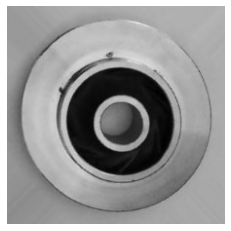

In [ ]:
import matplotlib.pyplot as plt

def to_PIL(img, mean=[0.5643], std=[0.2386]):
  trans = torchvision.transforms.ToPILImage()
  img =  img * torch.tensor([std])[:, None, None] + torch.tensor([mean])[:, None, None]
  return trans(img.squeeze())

img, lbl = ds_test[120]
print(img.shape, lbl)

img_2_show = to_PIL(img)
plt.imshow(img_2_show)
plt.axis('off')

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names


# https://github.com/sayakpaul/probing-vits
# https://arxiv.org/pdf/2108.08810.pdf

keys = ['encoder.layers.encoder_layer_0.ln',
        'encoder.layers.encoder_layer_1.ln',
        'encoder.layers.encoder_layer_2.ln',
        'encoder.layers.encoder_layer_3.ln',
        'encoder.layers.encoder_layer_4.ln',
        'encoder.layers.encoder_layer_5.ln',
        'encoder.layers.encoder_layer_6.ln',
        'encoder.layers.encoder_layer_7.ln',
        'encoder.layers.encoder_layer_8.ln',
        'encoder.layers.encoder_layer_9.ln',
        'encoder.layers.encoder_layer_10.ln',
        'encoder.layers.encoder_layer_11.ln',
        'heads']


### Pytorch implementation
feature_extractor = create_feature_extractor(model, return_nodes=keys)

### MY implementation
#feature_extractor = create_feature_extractor(model, return_nodes=keys)

model.eval()

out = feature_extractor(img.unsqueeze(0))
output = out['heads']

x_all = []
attn_all = []

### For the PYTORCH implementation
for i in range(12):
    x = out[keys[i]]
    x_, attn_ = model.encoder.layers[i].self_attention(x, x, x, need_weights=True, average_attn_weights=False)
    x_all.append(x_)
    attn_all.append(attn_)


### For MY implementation


In [ ]:
x_all[0].shape

torch.Size([1, 197, 768])

In [ ]:

def attn_mean(attn, patch_size = 16):
    
    w_featmap = img.shape[2] // patch_size
    h_featmap = img.shape[1] // patch_size

    nh = attn.shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attn[0, :, 0, 1:].reshape(nh, -1)
    #print(attentions.shape)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    #print(attentions.shape)
    #plt.imshow(attentions.mean(dim=0).detach().numpy())

    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = torchvision.transforms.Resize((h_featmap*patch_size, w_featmap*patch_size))(attentions)
    #print(attentions.shape)
    attn_mean = torch.mean(attentions, dim=0).detach().numpy()

    attentions = attentions.detach().numpy()


    #plt.imshow(attn_mean, cmap='inferno')
    return attn_mean, attentions

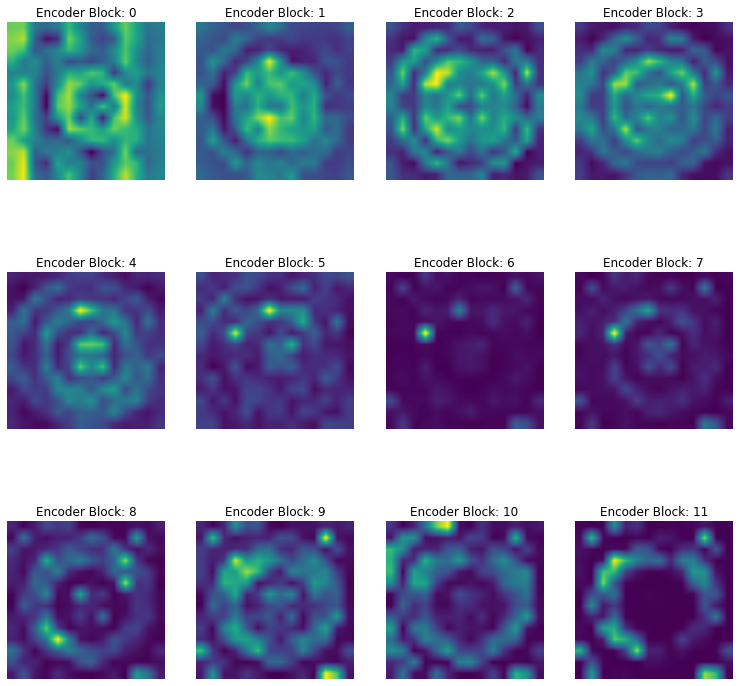

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))

for i, attn in enumerate(attn_all):
    im, _ = attn_mean(attn)
    x = i%4
    y = i//4
    axes[y, x].imshow(im)
    axes[y, x].title.set_text(f"Encoder Block: {i}")
    axes[y, x].axis("off")

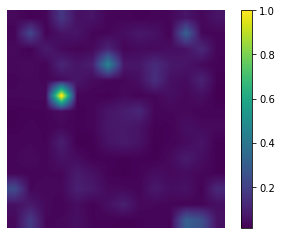

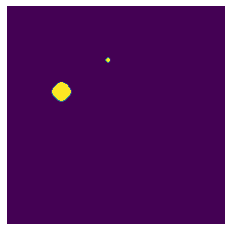

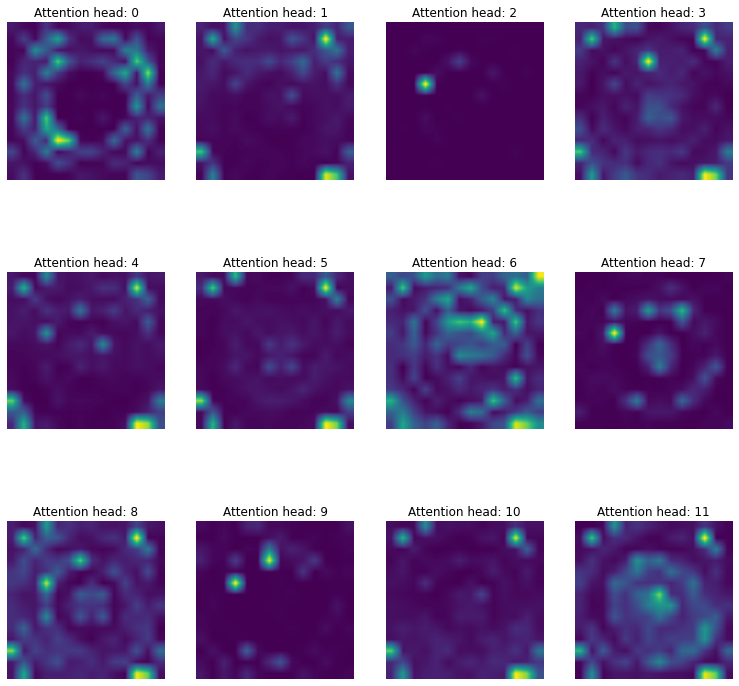

In [ ]:
block = 6

qwer, attentions = attn_mean(attn_all[block])

plt.imshow(qwer / qwer.max())
plt.axis("off")
plt.colorbar()
plt.show()

plt.imshow((qwer / qwer.max())>0.4)
plt.axis("off")
plt.show()

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < attentions.shape[0]:
            axes[i, j].imshow(attentions[img_count])
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

# ViT

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import cv2
import matplotlib.pyplot as plt


#model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/vit_2022_6_4.pth")
model = torchvision.models.vit_b_16(weights="ViT_B_16_Weights.IMAGENET1K_V1")


def to_PIL(img, mean=[0.5643], std=[0.2386]):
  trans = torchvision.transforms.ToPILImage()
  img =  img * torch.tensor([std])[:, None, None] + torch.tensor([mean])[:, None, None]
  return trans(img.squeeze())

def attn_mean(attn, patch_size = 16):
    w_featmap = img.shape[2] // patch_size
    h_featmap = img.shape[1] // patch_size

    nh = attn.shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attn[0, :, 0, 1:].reshape(nh, -1)
    
    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    
    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = torchvision.transforms.Resize((h_featmap*patch_size, w_featmap*patch_size))(attentions)
    attn_mean = torch.mean(attentions, dim=0).detach().numpy()

    attentions = attentions.detach().numpy()

    return attn_mean, attentions

key = ['encoder.layers.encoder_layer_6.ln']
feature_extractor = create_feature_extractor(model, return_nodes=key)
threshold = 0.4
iou_total = 0
iop_total = 0
n = 0

# Start loop
for i, (name, lbl) in enumerate(ds_test.samples):
    if lbl == 0:
        n += 1
        img, _ = ds_test[i]

        # Annotated
        mask = cv2.resize(plt.imread('/content/drive/MyDrive/Master_Thesis/DefectPosition/'+name.split('/')[-1].split('.')[0]+"_color_mask.png"), dsize=(224, 224))

        # ViT
        out = feature_extractor(img.unsqueeze(0))
        x = out[key[0]]
        x_, attn_ = model.encoder.layers[6].self_attention(x, x, x, need_weights=True, average_attn_weights=False)


        attention_mean, attentions = attn_mean(attn_)

        #norm_attn = attentions[9] / attentions[9].max()
        norm_attn = attention_mean / attention_mean.max()
        
        # Intersection over Union
        intersection = (mask[:, :, 1]==0) & (norm_attn>threshold)
        union = (mask[:, :, 1]==0) | (norm_attn>threshold)

        if union.sum() != 0:
            iou = intersection.sum() / union.sum()
            iou_total += iou

            iop = intersection.sum() / max((norm_attn>threshold).sum(), 1)
            iop_total += iop

        print(f"{n}\t {i} \tIoU: {iou:.2f} -> {iou_total:.2f}\tIoP:{iop:.2f} -> {iop_total:.2f}\t\t{name.split('/')[-1].split('.')[0]}_color_mask.png")

        # Plotting
        fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(28, 4))
        ax1.imshow(to_PIL(img))
        ax2.imshow(mask)
        ax3.imshow(mask[:, :, 1] == 0)
        ax4.imshow(norm_attn)
        ax5.imshow(norm_attn>threshold)
        ax6.imshow(union)
        ax7.imshow(intersection)
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        ax5.axis('off')
        ax6.axis('off')
        ax7.axis('off')

        plt.show()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

torch.Size([1, 12, 197, 197])


# Swin Transformer

In [ ]:
import torch.nn.functional as F
from typing import Optional, Callable, List, Any
from torch import Tensor


def shifted_window_attention(
    input: Tensor,
    qkv_weight: Tensor,
    proj_weight: Tensor,
    relative_position_bias: Tensor,
    window_size: List[int],
    num_heads: int,
    shift_size: List[int],
    attention_dropout: float = 0.0,
    dropout: float = 0.0,
    qkv_bias: Optional[Tensor] = None,
    proj_bias: Optional[Tensor] = None,
):
    """
    Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        input (Tensor[N, H, W, C]): The input tensor or 4-dimensions.
        qkv_weight (Tensor[in_dim, out_dim]): The weight tensor of query, key, value.
        proj_weight (Tensor[out_dim, out_dim]): The weight tensor of projection.
        relative_position_bias (Tensor): The learned relative position bias added to attention.
        window_size (List[int]): Window size.
        num_heads (int): Number of attention heads.
        shift_size (List[int]): Shift size for shifted window attention.
        attention_dropout (float): Dropout ratio of attention weight. Default: 0.0.
        dropout (float): Dropout ratio of output. Default: 0.0.
        qkv_bias (Tensor[out_dim], optional): The bias tensor of query, key, value. Default: None.
        proj_bias (Tensor[out_dim], optional): The bias tensor of projection. Default: None.
    Returns:
        Tensor[N, H, W, C]: The output tensor after shifted window attention.
    """
    B, H, W, C = input.shape
    # pad feature maps to multiples of window size
    pad_r = (window_size[1] - W % window_size[1]) % window_size[1]
    pad_b = (window_size[0] - H % window_size[0]) % window_size[0]
    x = F.pad(input, (0, 0, 0, pad_r, 0, pad_b))
    _, pad_H, pad_W, _ = x.shape

    # If window size is larger than feature size, there is no need to shift window
    if window_size[0] >= pad_H:
        shift_size[0] = 0
    if window_size[1] >= pad_W:
        shift_size[1] = 0

    # cyclic shift
    if sum(shift_size) > 0:
        x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))

    # partition windows
    num_windows = (pad_H // window_size[0]) * (pad_W // window_size[1])
    x = x.view(B, pad_H // window_size[0], window_size[0], pad_W // window_size[1], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).reshape(B * num_windows, window_size[0] * window_size[1], C)  # B*nW, Ws*Ws, C

    # multi-head attention
    qkv = F.linear(x, qkv_weight, qkv_bias)
    qkv = qkv.reshape(x.size(0), x.size(1), 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]
    q = q * (C // num_heads) ** -0.5
    attn = q.matmul(k.transpose(-2, -1))
    # add relative position bias
    attn = attn + relative_position_bias

    if sum(shift_size) > 0:
        # generate attention mask
        attn_mask = x.new_zeros((pad_H, pad_W))
        h_slices = ((0, -window_size[0]), (-window_size[0], -shift_size[0]), (-shift_size[0], None))
        w_slices = ((0, -window_size[1]), (-window_size[1], -shift_size[1]), (-shift_size[1], None))
        count = 0
        for h in h_slices:
            for w in w_slices:
                attn_mask[h[0] : h[1], w[0] : w[1]] = count
                count += 1
        attn_mask = attn_mask.view(pad_H // window_size[0], window_size[0], pad_W // window_size[1], window_size[1])
        attn_mask = attn_mask.permute(0, 2, 1, 3).reshape(num_windows, window_size[0] * window_size[1])
        attn_mask = attn_mask.unsqueeze(1) - attn_mask.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        attn = attn.view(x.size(0) // num_windows, num_windows, num_heads, x.size(1), x.size(1))
        attn = attn + attn_mask.unsqueeze(1).unsqueeze(0)
        attn = attn.view(-1, num_heads, x.size(1), x.size(1))

    attn_pre = attn.clone()
    attn = F.softmax(attn, dim=-1)
    attn = F.dropout(attn, p=attention_dropout)

    x = attn.matmul(v).transpose(1, 2).reshape(x.size(0), x.size(1), C)
    x = F.linear(x, proj_weight, proj_bias)
    x = F.dropout(x, p=dropout)

    # reverse windows
    x = x.view(B, pad_H // window_size[0], pad_W // window_size[1], window_size[0], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).reshape(B, pad_H, pad_W, C)

    # reverse cyclic shift
    if sum(shift_size) > 0:
        x = torch.roll(x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))

    # unpad features
    x = x[:, :H, :W, :].contiguous()
    return x, attn_pre

In [18]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import cv2
import matplotlib.pyplot as plt

model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/swin_t_2022_6_4.pth")
#model = torchvision.models.swin_t(weights="Swin_T_Weights.IMAGENET1K_V1")

tr, ev = get_graph_node_names(model)
for train in tr:
    print(train)

def to_PIL(img, mean=[0.5643], std=[0.2386]):
  trans = torchvision.transforms.ToPILImage()
  img =  img * torch.tensor([std])[:, None, None] + torch.tensor([mean])[:, None, None]
  return trans(img.squeeze())

def attn_mean_swin(attn, patch_size = 16):
    w_featmap = img.shape[2] // patch_size
    h_featmap = img.shape[1] // patch_size

    nh = attn.shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attn[0, :, 0, 1:].reshape(nh, -1)
    
    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    
    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = torchvision.transforms.Resize((h_featmap*patch_size, w_featmap*patch_size))(attentions)
    attn_mean = torch.mean(attentions, dim=0).detach().numpy()

    attentions = attentions.detach().numpy()

    return attn_mean, attentions

key = ['features.5.2.norm1']
layer = 5
block = 2

#key = ['features.5.5.attn.shifted_window_attention']
feature_extractor = create_feature_extractor(model, return_nodes=key)
threshold = 0.8
iou_total = 0
iop_total = 0
n = 0

cls = 30
h = 2

cls_list = []
h_list = []

searching = False
mean = True

iop_max = 0
cls_max = 0
h_max = 0

# Start loop
for i, (name, lbl) in enumerate(ds_test.samples):
    if lbl == 0:
        n += 1
        img, _ = ds_test[i]

        # Annotated
        mask = cv2.resize(plt.imread('/content/drive/MyDrive/Master_Thesis/DefectPosition/'+name.split('/')[-1].split('.')[0]+"_color_mask.png"), dsize=(224, 224))


        # Swin Extra
        N = model.features[layer][block].attn.window_size[0] * model.features[layer][block].attn.window_size[1]
        relative_position_bias = model.features[layer][block].attn.relative_position_bias_table[model.features[layer][block].attn.relative_position_index]
        relative_position_bias = relative_position_bias.view(N, N, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous().unsqueeze(0)

        # Swin
        out = feature_extractor(img.unsqueeze(0))
        x = out[key[0]]
        x_, attn_ = shifted_window_attention(x,
                                             model.features[layer][block].attn.qkv.weight,
                                             model.features[layer][block].attn.proj.weight,
                                             relative_position_bias,
                                             model.features[layer][block].attn.window_size,
                                             model.features[layer][block].attn.num_heads,
                                             shift_size=model.features[layer][block].attn.shift_size,
                                             attention_dropout=model.features[layer][block].attn.attention_dropout,
                                             dropout=model.features[layer][block].attn.dropout,
                                             qkv_bias=model.features[layer][block].attn.qkv.bias,
                                             proj_bias=model.features[layer][block].attn.proj.bias,
                                             )
        
        print(f"X: {x.shape}\t Attn: {attn_.shape}")
        
        
        #for b in range(attn_.shape[0]):
        #    fig, axs = plt.subplots(1, attn_.shape[1], figsize=(28, 4))
        #    for h in range(attn_.shape[1]):
        #        axs[h].imshow(attn_[b, h, cls].reshape(7,7).detach().numpy())
        #        axs[h].axis('off')   
        #    plt.show()

        
        if attn_.shape[0] == 1:
            for cls_ in range(attn_.shape[2]):
                fig, axs = plt.subplots(4, 6, figsize=(24, 16))
                cls = cls_
                print(cls)
                for h in range(attn_.shape[1]):
                    a = (torchvision.transforms.Resize((224, 224)))(attn_[0, cls, h].reshape(7, 7).unsqueeze(0))[0].detach().numpy()


        if attn_.shape[0] == 4:
            iop_max = 0
            if not searching:
                if mean:
                    a = torch.cat((attn_[0].mean(dim=(0))[0].reshape(7,7), attn_[2].mean(dim=(0))[0].reshape(7,7)), dim=0)
                    b = torch.cat((attn_[1].mean(dim=(0))[0].reshape(7,7), attn_[3].mean(dim=(0))[0].reshape(7,7)), dim=0)

                    c = (torchvision.transforms.Resize((224, 224)))(torch.cat((a, b), dim=1).unsqueeze(0))[0]
                    c = c + c.min().abs()
                    c = c / c.max()
                    #c = c > 0.8

                    attention_mean = c.detach().numpy()
                else:
                    a = torch.cat((attn_[0, h, cls].reshape(7,7), attn_[2, h, cls].reshape(7,7)), dim=0)
                    b = torch.cat((attn_[1, h, cls].reshape(7,7), attn_[3, h, cls].reshape(7,7)), dim=0)

                    c = (torchvision.transforms.Resize((224, 224)))(torch.cat((a, b), dim=1).unsqueeze(0))[0]
                    c = c + c.min().abs()
                    c = c / c.max()
                    c = c > 0.8

                    attention_mean = c.detach().numpy()
            else:
                for cls_ in range(attn_.shape[2]):
                    #fig, axs = plt.subplots(3, attn_.shape[1], figsize=(28, 4))
                    cls = cls_
                    #print(cls)
                    for h in range(attn_.shape[1]):
                        a = torch.cat((attn_[0, h, cls].reshape(7,7), attn_[2, h, cls].reshape(7,7)), dim=0)
                        b = torch.cat((attn_[1, h, cls].reshape(7,7), attn_[3, h, cls].reshape(7,7)), dim=0)

                        c = (torchvision.transforms.Resize((224, 224)))(torch.cat((a, b), dim=1).unsqueeze(0))[0]
                        
                        #axs[0, h].imshow(c.detach().numpy())
                        #axs[0, h].axis('off')

                        c = c + c.min().abs()
                        c = c / c.max()
                        c = c > 0.8

                        iop = ((mask[:, :, 1]==0) & (c.detach().numpy())) / max((c).sum(), 1)
                        if iop.sum() > iop_max:
                            attention_mean = c.detach().numpy()
                            cls_max = cls
                            h_max = h
                            iop_max = iop.sum()

                        #axs[1, h].imshow(c.detach().numpy())
                        #axs[1, h].axis('off')
                        #axs[2, h].imshow(iop)
                        #axs[2, h].axis('off')
                    #plt.show()

        if attn_.shape[0] == 16:
            fig, axs = plt.subplots(2, attn_.shape[1], figsize=(28, 4))
            for h in range(attn_.shape[1]):
                a_0 = torch.cat((attn_[ 0, h, cls].reshape(7,7), attn_[ 4, h, cls].reshape(7,7), attn_[ 8, h, cls].reshape(7,7), attn_[12, h, cls].reshape(7,7)), dim=0)
                a_1 = torch.cat((attn_[ 1, h, cls].reshape(7,7), attn_[ 5, h, cls].reshape(7,7), attn_[ 9, h, cls].reshape(7,7), attn_[13, h, cls].reshape(7,7)), dim=0)
                a_2 = torch.cat((attn_[ 2, h, cls].reshape(7,7), attn_[ 6, h, cls].reshape(7,7), attn_[10, h, cls].reshape(7,7), attn_[14, h, cls].reshape(7,7)), dim=0)
                a_3 = torch.cat((attn_[ 3, h, cls].reshape(7,7), attn_[ 7, h, cls].reshape(7,7), attn_[11, h, cls].reshape(7,7), attn_[15, h, cls].reshape(7,7)), dim=0)
                
                c = (torchvision.transforms.Resize((224, 224)))(torch.cat((a_0, a_1, a_2, a_3), dim=1).unsqueeze(0))[0]
                
                axs[0, h].imshow(c.detach().numpy())
                axs[0, h].axis('off')

                c = c + c.min().abs()
                c = c / c.max()
                c = c > 0.8

                if h == 0:
                    attention_mean = c.detach().numpy()

                axs[1, h].imshow(c.detach().numpy())
                axs[1, h].axis('off')
            plt.show()
        
        
        #attention_mean = (torchvision.transforms.Resize((224, 224)))(attn_[0].mean(dim=(0))[0].reshape(7, 7).unsqueeze(0))[0].detach().numpy()

        #attention_mean, attentions = attn_mean_swin(attn_, 32)

        #attention_mean = (torchvision.transforms.Resize((224, 224))(x.mean(dim=3)))[0].detach().numpy()
        
        norm_attn = attention_mean / attention_mean.max()
        
        # Intersection over Union
        intersection = (mask[:, :, 1]==0) & (norm_attn>threshold)
        union = (mask[:, :, 1]==0) | (norm_attn>threshold)

        if union.sum() != 0:
            iou = intersection.sum() / union.sum()
            iou_total += iou

            iop = intersection.sum() / max((norm_attn>threshold).sum(), 1)
            iop_total += iop

        print(f"{n}\t {i} \tIoU: {iou:.2f} -> {iou_total:.2f}\tIoP:{iop:.2f} -> {iop_total:.2f}\t\t{name.split('/')[-1].split('.')[0]}_color_mask.png")
        print(f"CLS_MAX: {cls_max}\t H_MAX: {h_max}")
        # Plotting
        fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(28, 4))
        ax1.imshow(to_PIL(img))
        ax2.imshow(mask)
        ax3.imshow(mask[:, :, 1] == 0)
        ax4.imshow(norm_attn)
        ax5.imshow(norm_attn>threshold)
        ax6.imshow(union)
        ax7.imshow(intersection)
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        ax5.axis('off')
        ax6.axis('off')
        ax7.axis('off')

        plt.show()

        cls_list.append(cls_max)
        h_list.append(h_max)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
iop_total

47.41163420784009

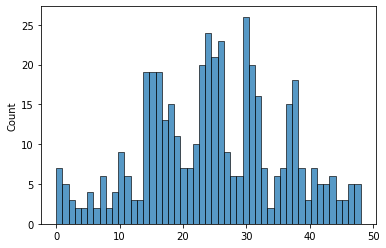

30


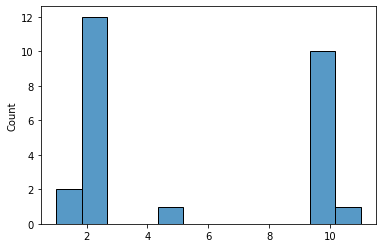

array([11, 10,  2,  2,  5, 10, 10,  1,  2,  2,  2,  2, 10,  2, 10,  2, 10,
       10,  2,  2, 10,  2,  2, 10, 10,  1])

In [ ]:
import seaborn as sns

sns.histplot(cls_list, bins = 49)
plt.show()

print(max(set(cls_list), key=cls_list.count))

sns.histplot(np.asarray(h_list)[np.where(np.asarray(cls_list)==30)], bins=12)
plt.show()


np.asarray(h_list)[np.where(np.asarray(cls_list)==30)]

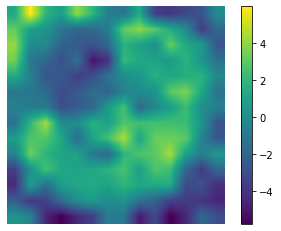

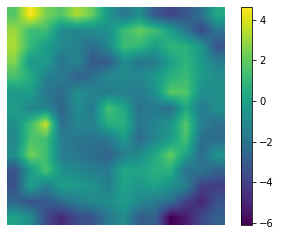

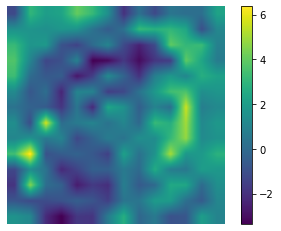

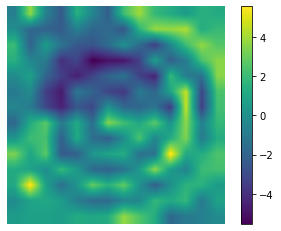

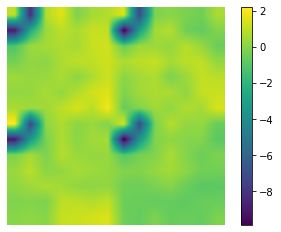

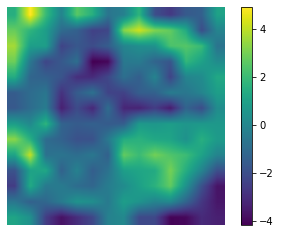

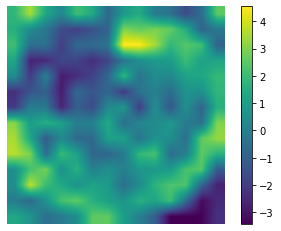

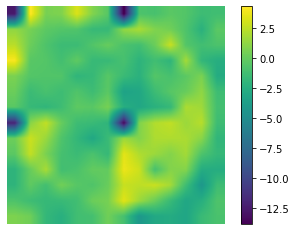

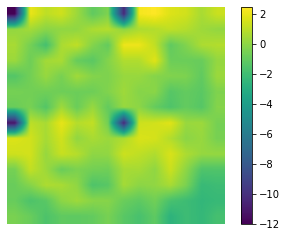

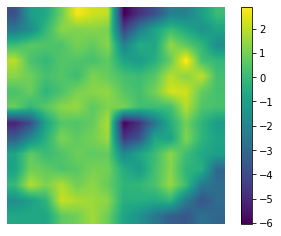

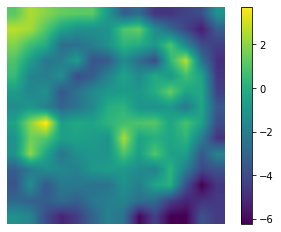

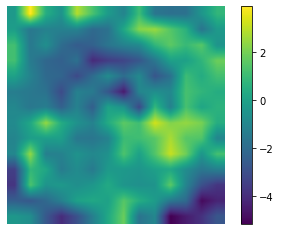

In [ ]:
#a = torch.cat((attn_[0, 6, 0].reshape(7,7), attn_[1, 6, 0].reshape(7,7)), dim=0)
#b = torch.cat((attn_[2, 6, 0].reshape(7,7), attn_[3, 6, 0].reshape(7,7)), dim=0)

for i in range(attn_.shape[1]):
    a = torch.cat((attn_[0, i, 0].reshape(7,7), attn_[2, i, 0].reshape(7,7)), dim=0)
    b = torch.cat((attn_[1, i, 0].reshape(7,7), attn_[3, i, 0].reshape(7,7)), dim=0)

    c = (torchvision.transforms.Resize((224, 224)))(torch.cat((a, b), dim=1).unsqueeze(0))[0]
    
    plt.imshow(c.detach().numpy())
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [ ]:
print(torch.nn.Softmax()(model(img.unsqueeze(0))))
print(lbl)

tensor([[1.0000e+00, 3.2544e-06]], grad_fn=<SoftmaxBackward0>)
0


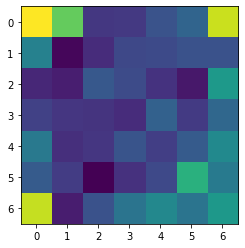

In [ ]:
plt.imshow(attn_[0, 11, 0].reshape(7, 7).detach().numpy())

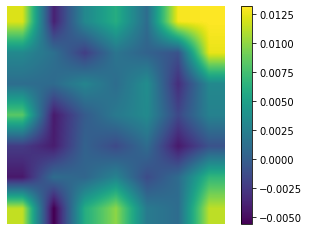

In [ ]:
x2 = (torchvision.transforms.Resize((224, 224))(x.mean(dim=3)))[0].detach().numpy()
plt.imshow(x2)
plt.colorbar()
plt.axis('off')
plt.show()

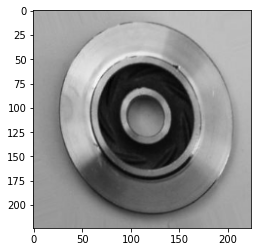

In [ ]:
plt.imshow(to_PIL(img))

# DINO

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


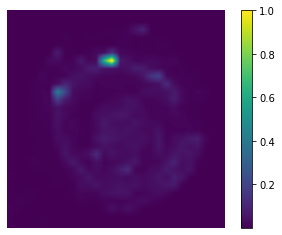

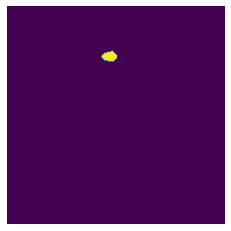

In [ ]:
model = DiNo()
model = torch.utils.model_zoo.load_url("https://drive.google.com/uc?export=download&id=1-H40C6fYLaqg4049xIOPV4F20LnWeZfm&confirm=t", "models/dino")


img, _ = ds_test[120]
attn = model.backbone.get_last_selfattention(img.unsqueeze(0))

im, _ = attn_mean(attn, 8)
norm_attn = im/im.max()

plt.imshow(norm_attn)
plt.axis("off")
plt.colorbar()
plt.show()

plt.imshow(norm_attn>0.4)
plt.axis("off")
plt.show()

In [ ]:
#model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/dino_2022_6_4.pth")
model = DiNo()
#model = torch.utils.model_zoo.load_url("https://drive.google.com/uc?export=download&id=1-H40C6fYLaqg4049xIOPV4F20LnWeZfm&confirm=t", "models/dino")


iou_total = 0
iop_total = 0
n = 0
threshold = 0.4

for i, (name, lbl) in enumerate(ds_test.samples):
    if lbl == 0:
        n += 1
        img, _ = ds_test[i]

        # Annotated
        mask = cv2.resize(plt.imread('/content/drive/MyDrive/Master_Thesis/DefectPosition/'+name.split('/')[-1].split('.')[0]+"_color_mask.png"), dsize=(224, 224))

        # DINO
        attn = model.backbone.get_last_selfattention(img.unsqueeze(0))
        im, _ = attn_mean(attn, 8)
        norm_attn = im/im.max()

        # Intersection over Union
        intersection = (mask[:, :, 1]==0) & (norm_attn>threshold)
        union = (mask[:, :, 1]==0) | (norm_attn>threshold)

        if union.sum() != 0:
            iou = intersection.sum() / union.sum()
            iou_total += iou

            iop = intersection.sum() / max((norm_attn>threshold).sum(), 1)
            iop_total += iop

        print(f"{n}\t {i} \tIoU: {iou:.2f} -> {iou_total:.2f}\tIoP:{iop:.2f} -> {iop_total:.2f}\t\t{name.split('/')[-1].split('.')[0]}_color_mask.png")

        # Plotting
        fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(28, 4))
        ax1.imshow(to_PIL(img))
        ax2.imshow(mask)
        ax3.imshow(mask[:, :, 1] == 0)
        ax4.imshow(norm_attn)
        ax5.imshow(norm_attn>threshold)
        ax6.imshow(union)
        ax7.imshow(intersection)
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        ax5.axis('off')
        ax6.axis('off')
        ax7.axis('off')

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(iou_total)
print(iop_total)
n

28.38597939669653
57.67871264882204


453

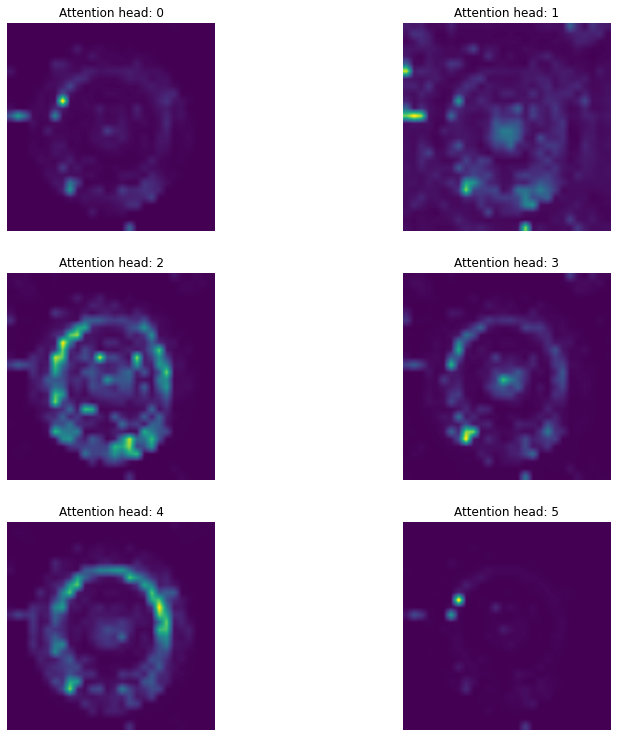

In [ ]:
_, attentions = attn_mean(attn, 8)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(2):
        if img_count < attentions.shape[0]:
            axes[i, j].imshow(attentions[img_count])
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

# My GradCAM - ConvNext

In [ ]:
model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/convnext_2022_05_13.pth")
#model.features[-1][-1].block[0]

model.eval()

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

#print(torchvision.models.feature_extraction.get_graph_node_names(model))

return_nodes = {
    'classifier.2': 'classifier.2',
    'features.7.0.block.0': 'features.7.0.block.0'}

body = create_feature_extractor(model, return_nodes=return_nodes)


img = ds_test[4]

out = body(img[0].unsqueeze(0))

print(out['classifier.2'].argmax(dim=1))
tmp = out['features.7.0.block.0']

out['classifier.2'][:, 0].backward()

torch.all(tmp == out['features.7.0.block.0'])

tensor([0])


tensor(True)

In [ ]:
gradients = out['features.7.0.block.0']

pooled_gradients = torch.mean(gradients, dim=[0,2,3])

In [ ]:
gradients.shape

torch.Size([1, 768, 9, 9])

In [ ]:
torchvision.models.feature_extraction.get_graph_node_names(model)

(['x',
  'features.0.0',
  'features.0.1.permute',
  'features.0.1.features_0_1_weight',
  'features.0.1.features_0_1_bias',
  'features.0.1.layer_norm',
  'features.0.1.permute_1',
  'features.1.0.features_1_0_layer_scale',
  'features.1.0.block.0',
  'features.1.0.block.1.permute',
  'features.1.0.block.2',
  'features.1.0.block.3',
  'features.1.0.block.4',
  'features.1.0.block.5',
  'features.1.0.block.6.permute',
  'features.1.0.mul',
  'features.1.0.stochastic_depth',
  'features.1.0.add',
  'features.1.1.features_1_1_layer_scale',
  'features.1.1.block.0',
  'features.1.1.block.1.permute',
  'features.1.1.block.2',
  'features.1.1.block.3',
  'features.1.1.block.4',
  'features.1.1.block.5',
  'features.1.1.block.6.permute',
  'features.1.1.mul',
  'features.1.1.stochastic_depth',
  'features.1.1.add',
  'features.1.2.features_1_2_layer_scale',
  'features.1.2.block.0',
  'features.1.2.block.1.permute',
  'features.1.2.block.2',
  'features.1.2.block.3',
  'features.1.2.block.4

# GradCAM

In [ ]:
!pip install grad-cam

     |████████████████████████████████| 4.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=daf23c331550a553561e4cffb270af786dc05b4f94d3ffbed05610a4db52f672
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

target_layers = [model.encoder.layers[-1].ln_1]

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform, use_cuda=True)

In [ ]:
targets = [ClassifierOutputTarget(0)]
grayscale_cam = cam(input_tensor=img.unsqueeze(0), targets=targets)

grayscale_cam = grayscale_cam[0, :]
rgb_img = img.permute(1, 2, 0).detach().numpy() / 255
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

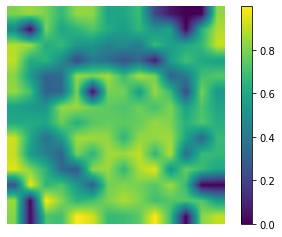

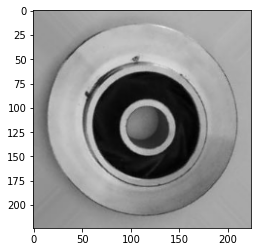

In [ ]:
plt.imshow(grayscale_cam)
plt.colorbar()
plt.axis("off")
plt.show()
plt.imshow(img_2_show)

# CAPTUM

## Install

In [ ]:
!pip install captum

     |████████████████████████████████| 1.4 MB 5.1 MB/s 


## Import

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

## Trying Captum out

In [ ]:
#swin_t_model = torch.utils.model_zoo.load_url("https://drive.google.com/uc?export=download&id=1-4MKJzlIWcWQeb5D8Ly7aJhfk29fz9-c&confirm=t", "models/swin")
resnet18_model = torch.utils.model_zoo.load_url("https://drive.google.com/uc?export=download&id=1-Dh-hAa6OIQaU6PMlNXmy9NCAWLrgY7U&confirm=t", "models/resnet18")
model = resnet18_model

img, lbl = ds_test[5]
print(lbl)
input = img.unsqueeze(0)

output = model(input)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

idx_to_labels = {"0": 'def', "1":'ok'}

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

0
Predicted: def ( 0.5963407754898071 )


In [ ]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
print("here")
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)
print("done")

Predicted: def ( 0.5956355929374695 )
here
done


In [ ]:
mean= torch.tensor([0.5643, 0.5643, 0.5643]) 
std = torch.tensor([0.2386, 0.2386, 0.2386])

transformed_img =  img * std[:, None, None] + mean[:, None, None]
  

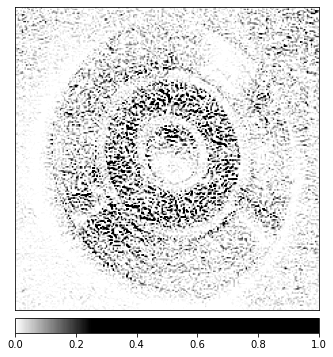

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

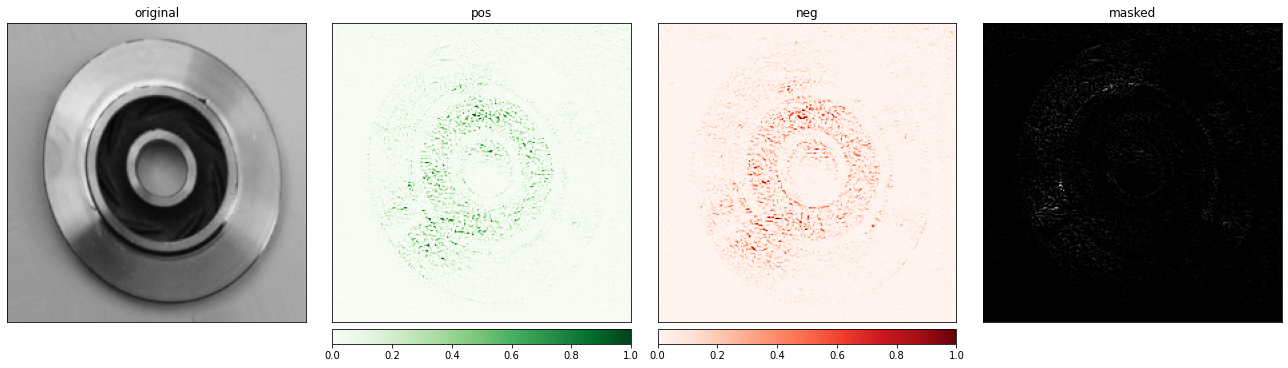

In [ ]:
gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      #cmap=default_cmap,
                                      show_colorbar=True,
                                      titles=["original", "pos", "neg", "masked"],
                                      fig_size=(18,6))

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 15, 15),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

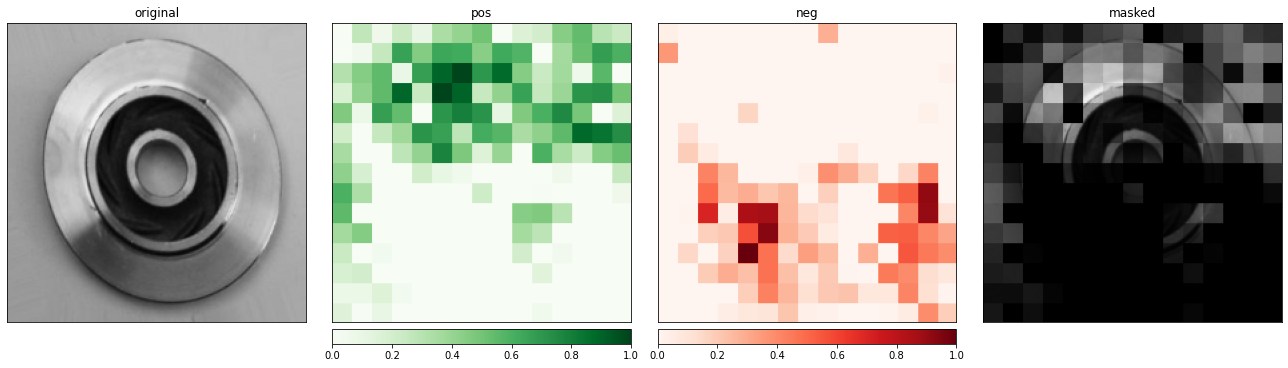

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      #cmap=default_cmap,
                                      show_colorbar=True,
                                      titles=["original", "pos", "neg", "masked"],
                                      fig_size=(18,6))

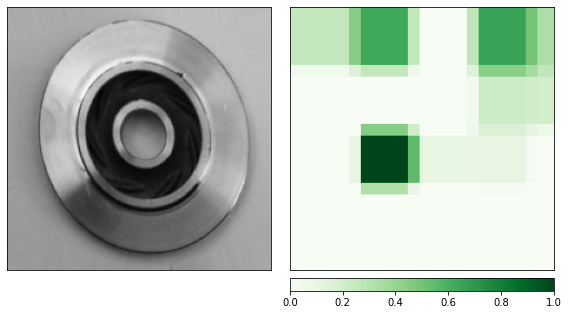

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

# SHAP

## Install and import

In [ ]:
!pip install shap
import shap

     |████████████████████████████████| 564 kB 29.8 MB/s 


## Using shap

In [ ]:
batch = next(iter(dl_train))
imgs, _ = batch

DEF


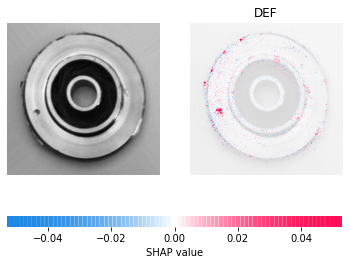

In [ ]:
classes = ["DEF", "OK"]
mean = torch.tensor([0.3460, 0.4832, 0.7033])
std = torch.tensor([1.0419, 1.0652, 1.0605])

e = shap.GradientExplainer(model, imgs)

img, lbl = ds_test[501]
print(classes[lbl])

shap_values,indexes = e.shap_values(img.unsqueeze(0), ranked_outputs=1, nsamples=200)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
index_names = np.vectorize(lambda x: classes[x])(indexes)
shap.image_plot(shap_values, 
    ((img 
      * std[:, None, None] 
      + mean[:, None, None])).permute(1, 2, 0).unsqueeze(0).numpy(), 
    index_names)


In [ ]:
import matplotlib.pyplot as plt

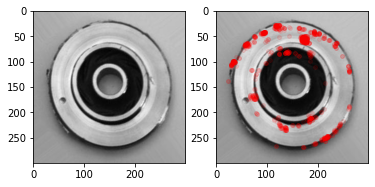

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

plt_img = ((img
                  * std[:, None, None] 
                  + mean[:, None, None])).permute(1, 2, 0).numpy()

ax1.imshow(plt_img)
ax2.imshow(plt_img)
x, y, rgb = np.where(shap_values[0][0]>0.01)
ax2.scatter(x, y, s=15, c='r', alpha=0.1)
fig.show()

In [ ]:
[print(a if isinstance(a, float) else 0) for a in shap_values[0][0][x,y,rgb]]

0.015539911733581104
0.013163499147866204
0.016637851025267617
0.027975334792233644
0.04019961791180633
0.02927689563874168
0.04559775184901334
0.022652709845097086
0.0340600415991055
0.011886873231868149
0.010889153034938037
0.018830498470276447
0.012544770839195035
0.010484055262831441
0.010945239024493285
0.012602894938290081
0.013253954510889723
0.011027869410047903
0.017872304784737735
0.011530209487398677
0.0173482123048334
0.013565912325811568
0.01001556535096849
0.01688620000227089
0.02102659114494097
0.011896840060563674
0.011815529744563211
0.03972432225447006
0.018159871447888856
0.03656640661595125
0.027260659248769446
0.01548552753031739
0.04011998468677846
0.014938297753205616
0.012443051901022857
0.012084226049942061
0.05355727149002651
0.048364886254906335
0.05588017211068031
0.027899728777161164
0.06276553074823106
0.030957060625299748
0.05563728516727878
0.10700682452843907
0.03355403789388438
0.08589749530553817
0.02174219697940589
0.024135647420720677
0.024002955619

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
shap_values[0][0][x,y,rgb]

0.011376886485051587

# Load pretrained weights from url

In [ ]:
model = timm.models.convnext.convnext_tiny()
model.head.fc = torch.nn.Linear(768, 2)
state_dict = torch.hub.load_state_dict_from_url("https://drive.google.com/uc?export=download&id=1eTbkcFYrxbSxJ4Jj0BpH1_mbLqJQ0LmP&confirm=t")
model.load_state_dict(state_dict)

Downloading: "https://drive.google.com/uc?export=download&id=1eTbkcFYrxbSxJ4Jj0BpH1_mbLqJQ0LmP&confirm=t" to /root/.cache/torch/hub/checkpoints/uc


  0%|          | 0.00/106M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
model = timm.models.efficientnetv2_rw_s()
model.classifier = torch.nn.Linear(1792, 2)
state_dict = torch.hub.load_state_dict_from_url("https://drive.google.com/uc?export=download&id=1xFlpR2vQvwn8YnMXo2Fgtk0Wr5FmJHvM&confirm=t")
#state_dict = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/efficientnetv2.pth.tar")
model.load_state_dict(state_dict)

RuntimeError: ignored

In [ ]:
for i, (img, lbl) in enumerate(ds_test):

    out = int(model(img.unsqueeze(0)).softmax(1).argmax())

    if lbl != out:
        print(f"{i} - Ground truth: {lbl} \t Prediction: {out} \t Img: {ds_test.samples[i]}")

0 - Ground truth: 1 	 Prediction: 0 	 Img: ('/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/test/ok_front/cast_ok_0_268.jpeg', 1)
1 - Ground truth: 1 	 Prediction: 0 	 Img: ('/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/test/ok_front/cast_ok_0_235.jpeg', 1)
2 - Ground truth: 1 	 Prediction: 0 	 Img: ('/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/test/ok_front/cast_ok_0_2840.jpeg', 1)
3 - Ground truth: 1 	 Prediction: 0 	 Img: ('/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/test/ok_front/cast_ok_0_8172.jpeg', 1)
8 - Ground truth: 1 	 Prediction: 0 	 Img: ('/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/test/ok_front/cast_ok_0_3278.jpeg', 1)
11 - Ground truth: 1 	 Prediction: 0 	 Img: ('/content/drive/MyDrive/Master_Thesis/Casting_P

KeyboardInterrupt: ignored

In [ ]:
model.stages.convnextstage

AttributeError: ignored

In [ ]:
model = zdmp.get_luna()
state_dict = torch.hub.load_state_dict_from_url("https://drive.google.com/uc?export=download&id=1--QLazObKI6sp0xtvYZ_jShrLlGMqfut&confirm=t")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from torchsummary import summary

model.cuda()  
summary(model, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 150, 150]             648
       BatchNorm2d-2         [-1, 24, 150, 150]              48
              SiLU-3         [-1, 24, 150, 150]               0
            Conv2d-4         [-1, 24, 150, 150]           5,184
       BatchNorm2d-5         [-1, 24, 150, 150]              48
              SiLU-6         [-1, 24, 150, 150]               0
          Identity-7         [-1, 24, 150, 150]               0
            Conv2d-8         [-1, 24, 150, 150]             576
       BatchNorm2d-9         [-1, 24, 150, 150]              48
     EdgeResidual-10         [-1, 24, 150, 150]               0
           Conv2d-11         [-1, 24, 150, 150]           5,184
      BatchNorm2d-12         [-1, 24, 150, 150]              48
             SiLU-13         [-1, 24, 150, 150]               0
         Identity-14         [-1, 24, 1

  0%|          | 0/5970 [00:00<?, ?it/s]

0 663
(array([   2,    9,   14,   37,   57,  101,  170,  235,  304,  432,  542,
        567,  542,  479,  525,  525,  521,  508,  527,  565,  525,  481,
        472,  446,  370,  292,  305,  273,  234,  238,  227,  227,  223,
        216,  209,  200,  196,  152,  164,  141,  154,  163,  158,  137,
        145,  133,  125,  135,  134,  119,  129,  110,  111,  110,  107,
        112,  107,  116,  116,  107,  100,  117,  115,  117,  112,   90,
        106,  117,  133,  141,  103,  122,  105,  111,  101,  106,  107,
        113,  130,  113,  131,  102,  107,  111,  121,  116,  126,  117,
        114,  120,  125,  139,  136,  148,  148,  146,  139,  151,  119,
        156,  162,  152,  178,  212,  181,  200,  191,  245,  248,  248,
        282,  284,  301,  295,  346,  363,  405,  430,  451,  482,  471,
        471,  521,  512,  603,  531,  630,  835, 1106, 1093,  940,  988,
       1116,  962,  878, 1366,  719,  674,  769,  779,  811,  666,  535,
        561,  544,  577,  573,  565,  608,  

<BarContainer object of 256 artists>

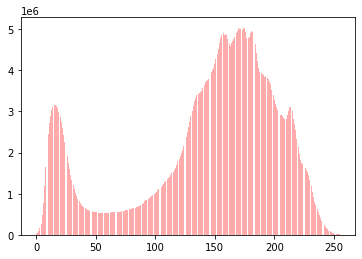

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

nb_bins = 256
count_r = np.zeros(nb_bins)
count_g = np.zeros(nb_bins)
count_b = np.zeros(nb_bins)

c_list_val = 0

#for folder in os.listdir('/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/train'): 
#    dir = '/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/train/'+folder
#    for image in tqdm(os.listdir(dir)):
#        if (dir+"/"+image) in listado_train:
#           img = Image.open(dir+"/"+image)
#           x = np.array(img)
#           x = x.transpose(2, 0, 1)

for image, lbl in tqdm(ds_train):
    x = image.numpy() * 256.0 

    hist_r = np.histogram(x[0], bins=nb_bins, range=[0, 256])
    count_r += hist_r[0]
        #else:
            #c_list_val += 1
    
print(c_list_val, len(ds_vali))
print(hist_r)

bins = hist_r[1]
fig = plt.figure()
plt.bar(bins[:-1], count_r, color='r', alpha=0.33)

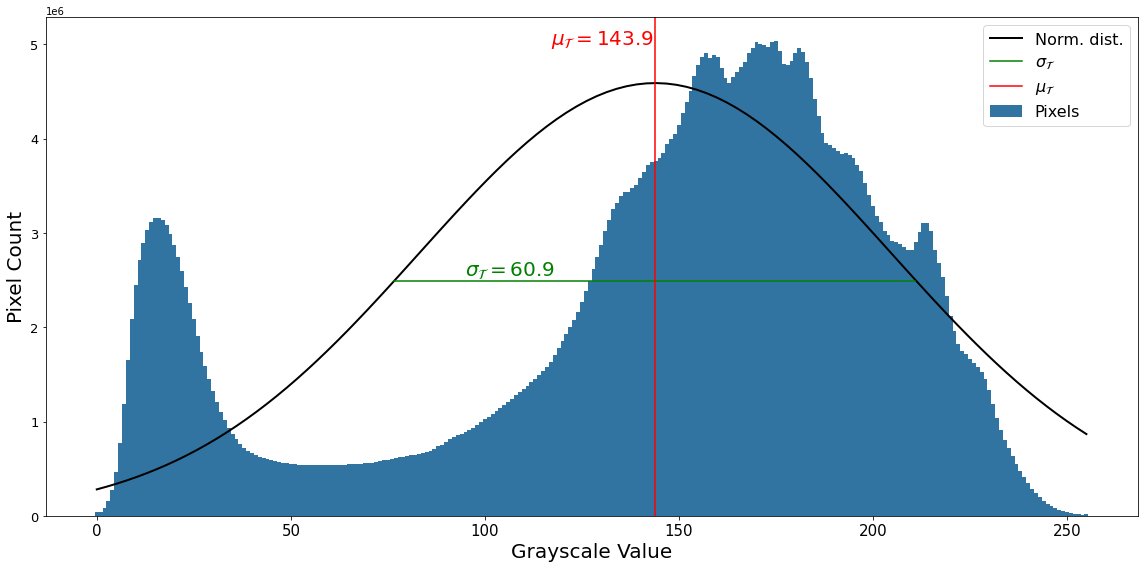

In [ ]:
import seaborn as sns
import pandas as pd
import scipy.stats as stats

x = np.zeros((256, 2))
x[:, 0] = np.round(bins[:-1])
x[:, 1] = count_r

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

plt.figure(figsize=(16,8))
ax = sns.barplot(x=x[:,0]+0.5, y=x[:,1], color='tab:blue', label="Pixels") 
plt.xticks([0, 50, 100, 150, 200, 250],['0', '50', '100', '150', '200', '250'], fontsize=15)
plt.yticks(fontsize=13)
plt.xlabel("Grayscale Value", size=20)
plt.ylabel("Pixel Count", size=20)


mu = 143.898
sigma = 0.23862334957123854*255
x = np.linspace(0, 255, 100) 
plt.plot(x, stats.norm.pdf(x, mu, sigma)*7e8, color='k', lw=2, label='Norm. dist.')

c = 1.8
min = (mu - sigma - c)/255
max = (mu + sigma - c)/255
plt.axhline(y=2.49e6, xmin=min, xmax=max, label=r'$\sigma_\mathcal{T}$', color='g')
plt.text(95,2.54e6,r'$\sigma_\mathcal{T}=60.9$',fontsize=20, color='g')

plt.axvline(x=143.898, color='r', label=r'$\mu_\mathcal{T}$')
plt.text(117,5e6,r'$\mu_\mathcal{T}=143.9$',fontsize=20, color='r')

plt.legend(prop={'size': 16})

plt.tight_layout()
change_width(ax, 1)
plt.show()

In [ ]:
suma = 0
cant = 0
var=0

for i, n in enumerate(count_r):
    cant += n
    suma += n * i
    var += n * ((i - 143.87806002479186)/255)**2

print(cant, suma, suma/(cant), suma/(cant*255), (var/cant)**0.5)

537300000.0 125462297931.0 233.50511433277498 0.9157063307167647 0.5701025421782621


In [ ]:
listado_train = []

for idx in ds_train.indices:
    listado_train.append(ds_train.dataset.samples[idx][0])
    

In [ ]:
x = np.array(ds_train[0][0].numpy())
print(np.shape(x[0]))

hist_r = np.histogram(x[0], bins=200, range=[-3, 3])
print(hist_r)

(300, 300)
(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 15149,  1429,  1349,   726,     0,  1017,
         684,   504,   229,   191,   282,   112,   224,   107,   160,
          77,   161,    78,    64,   149,   138,    70,    76,   145,
         131,    70,     0,   155,   157,   145,    96,   173,   112,
          90,   169,    82,   166,   189,    86,   182,   119,   118,
         208,    99,    92,   219,   188,   118,   112,   115,   226,
         254,   256,   153,   290,     0,   409,   246,   519,   573,
         610,   342,   362,   446,   828,   929,     0,  1075,   968,
         444,   369,   745,   392,   806,   754,   638,  1579,   773,
         687,  1365,   563,  1279,   979,   440,   394,   492,   844,
         575,   297,   274,   521,   577,   269,   338,   786,   436,
         919,   593,  1053,   657,  1202,   647,   915,  1955,  2248,
        